# A/A и A/B тесты: симуляция и анализ p-value

В этом ноутбуке рассматривается поведение p-value
в A/A и A/B тестах на синтетических данных.

Цель:
- проверить корректность статистического теста (A/A),
- проанализировать распределение p-value,
- наглядно показать различие между отсутствием эффекта и наличием эффекта,
- связать p-value, уровень значимости α и статистическую мощность теста.

__Параметры:__

_CPA (cost-per-action) - плата за действие_\
_CVR (`conversion_rate`) — конверсия совершения действия (action) пользователем_\
_CPC (cost-per-click) – плата за клик (за переход), рассчитывается как CVR * CPA_\
_`n_simulations` - сколько A/B(A/A) тестов смоделируем_\
_`n_samples` - размер группы_\
_`mde` -  (minimal detectable effect) — минимальный эффект, который мы можем поймать_\
_`reward_avg` - среднее значение для симуляции выборок_\
_`reward_std` - стандартное отклонение для симуляции выборок_


In [16]:
from typing import Tuple, List

import numpy as np
from scipy.stats import ttest_ind
from scipy import stats
import matplotlib.pyplot as plt

## Генерация синтетических данных

Для проведения A/A и A/B тестов используются синтетические выборки.
Это позволяет контролировать параметры эксперимента
и точно знать, существует ли реальный эффект между группами.


In [3]:
def cpc_sample(
    n_samples: int, conversion_rate: float, reward_avg: float, reward_std: float
) -> np.ndarray:
    """
    Генерируем простые тестовые выборки (симуляции)
    Функция принимает на вход размер выборки n_samples, конверсию conversion_rate, среднее значение 
    и стандартное отклонение вознаграждения за action: reward_avg и reward_std
    """
    # Сгенерируем CVR, используя биномиальное распределение. На выходе мы хотим получить массив 0 и 1 
    # (было совершено действие action или нет), где количество единиц появляется с определенной конверсией (вероятностью) cvr.
    cvr = np.random.binomial(1, conversion_rate, size=n_samples)

    # Сгенерируем CPA из нормального распределения с параметрами (reward_avg — среднее значение и reward_std — стандартное отклонение).
    cpa = np.random.normal(reward_avg, reward_std, size=n_samples)

    # Рассчитаем CPC по формуле CVR * CPA.
    cpc = cpa * cvr
    return cpc

Здесь моделируется метрика CPC как произведение:
- бинарной конверсии (CVR),
- вознаграждения за действие (CPA).

Такой подход отражает типичную бизнес-метрику,
используемую в рекламных и маркетинговых экспериментах.


## Статистический тест

Для сравнения двух выборок используется двухвыборочный t-тест.
Он проверяет нулевую гипотезу о равенстве средних значений метрики
в двух группах.

*_В рамках симуляции предполагается равенство дисперсий, что соответствует стандартному t-тесту._


In [2]:
def t_test(cpc_a: np.ndarray, cpc_b: np.ndarray, alpha=0.05
) -> Tuple[bool, float]:
    """
    На вход функция принимает две выборки и уровень значимости alpha. 
    Возвращает:
    True (если различие между выборками статистически значимо)
    False (если нет)
    значение p-value
    """

    # Используем t-тест из scipy
    stat, p_value = ttest_ind(cpc_a, cpc_b, equal_var=True)
    return bool(p_value < alpha), float(p_value)

## A/A тест

A/A тест используется как sanity-check статистического теста.

Поскольку обе группы имеют одинаковые параметры распределения,
нулевая гипотеза всегда истинна.
Ожидается, что:
- p-value распределены равномерно на [0, 1],
- доля ложных срабатываний близка к уровню значимости α.


In [5]:
def aa_test_pvalues(
    n_simulations: int,
    n_samples: int,
    conversion_rate: float,
    reward_avg: float,
    reward_std: float,
) -> np.ndarray:
    """Собираем p-value для синтетического A/A-теста"""
    p_values = np.zeros(n_simulations)

    for i in range(n_simulations):
        # Две группы с одинаковыми параметрами
        cpc_a = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)
        cpc_b = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)

        _, p_value = t_test(cpc_a, cpc_b)
        p_values[i] = p_value

    return p_values

In [7]:
def ab_test_pvalues(
    n_simulations: int,
    n_samples: int,
    conversion_rate: float,
    mde: float,
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
) -> np.ndarray:
    """Собираем p-value для синтетического A/B-теста"""
    p_values = np.zeros(n_simulations)

    for i in range(n_simulations):
        # Группа A: базовая конверсия
        cpc_a = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)
        # Группа B: конверсия * (1 + mde)
        cpc_b =cpc_sample(n_samples, conversion_rate * (1 + mde), reward_avg, reward_std)

        _, p_value = t_test(cpc_a, cpc_b, alpha=alpha)
        p_values[i] = p_value

    return p_values


### Сравнение распределений p-value в A/A и A/B тестах

In [8]:
# Параметры синтетических A/B и A/A тестов
n_simulations = 5000       
n_samples = 2000           
conversion_rate = 0.10     # базовый CR
mde = 0.1                  # +10% к CR в группе B
reward_avg = 10.0
reward_std = 2.0
alpha = 0.09

In [12]:
p_values_aa = aa_test_pvalues(
    n_simulations=10_000,
    n_samples=1_000,
    conversion_rate=0.1,
    reward_avg=100,
    reward_std=20,
)
p_values_ab = ab_test_pvalues(
    n_simulations=10_000,
    n_samples=1_000,
    conversion_rate=0.1,
    mde=0.1,
    reward_avg=100,
    reward_std=20,
)

### Распределение p-value в A/A тесте

При корректной работе статистического теста
p-value в A/A тесте должны иметь равномерное распределение.


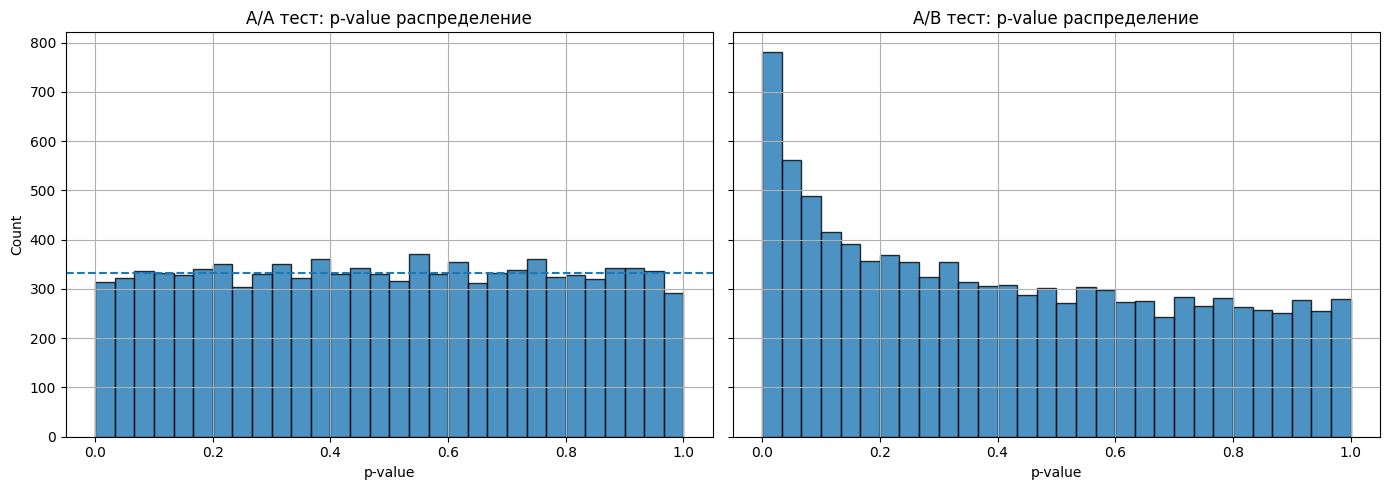

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# A/A test
axes[0].hist(
    p_values_aa,
    bins=30,
    edgecolor="black",
    alpha=0.8
)
axes[0].axhline(
    y=len(p_values_aa) / 30,
    linestyle="--",
)
axes[0].set_title("A/A тест: p-value распределение")
axes[0].set_xlabel("p-value")
axes[0].set_ylabel("Count")
axes[0].grid(True)

# A/B test
axes[1].hist(
    p_values_ab,
    bins=30,
    edgecolor="black",
    alpha=0.8
)
axes[1].set_title("A/B тест: p-value распределение")
axes[1].set_xlabel("p-value")
axes[1].grid(True)

plt.tight_layout()
plt.show()



В A/A-тесте нулевая гипотеза истинна, поэтому p-value
имеют равномерное распределение на интервале [0, 1].

В A/B-тесте между группами существует реальное различие
(эффект размера `mde`), поэтому распределение p-value
смещается в сторону малых значений.

Чем больше доля p-value < α, тем выше статистическая мощность теста.


In [14]:
alpha = 0.05

print("A/A: P(p < alpha) =", np.mean(p_values_aa < alpha))
print("A/B: P(p < alpha) =", np.mean(p_values_ab < alpha))


A/A: P(p < alpha) = 0.0478
A/B: P(p < alpha) = 0.1074


Доля p-value < α в A/B-тесте существенно выше,
чем в A/A-тесте, что отражает наличие реального эффекта.


### ECDF p-value для A/A и A/B тестов

Эмпирическая функция распределения (ECDF) p-value
показывает долю симуляций, в которых p-value не превышает заданного значения.

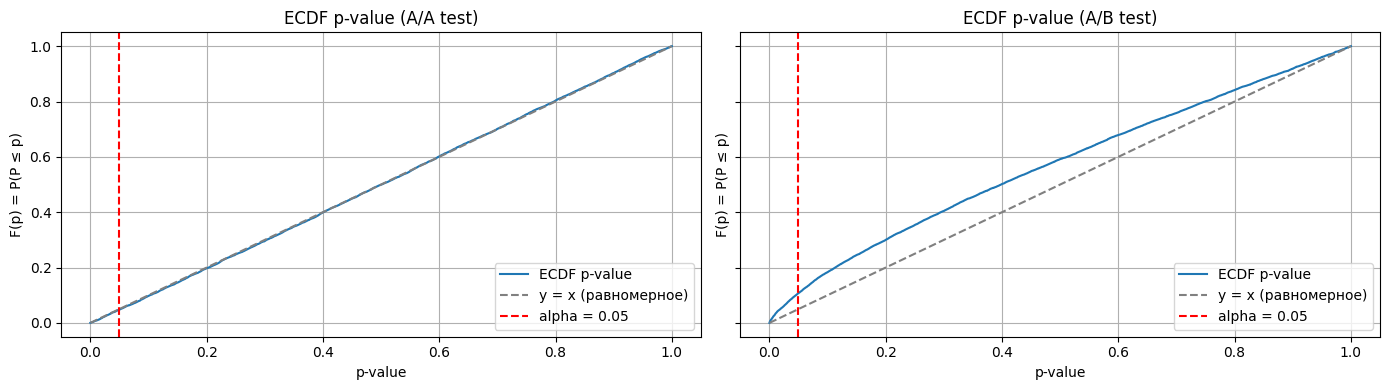

In [15]:
def plot_ecdf(p_values, ax, title, alpha):
    # Сортируем p-value
    sorted_p = np.sort(p_values)
    ecdf = np.arange(1, len(sorted_p) + 1) / len(sorted_p)

    ax.plot(sorted_p, ecdf, label="ECDF p-value")
    ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="y = x (равномерное)")
    ax.axvline(alpha, color="red", linestyle="--", label=f"alpha = {alpha}")

    ax.set_xlabel("p-value")
    ax.set_ylabel("F(p) = P(P ≤ p)")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

plot_ecdf(
    p_values_aa,
    axes[0],
    title="ECDF p-value (A/A test)",
    alpha=alpha,
)

plot_ecdf(
    p_values_ab,
    axes[1],
    title="ECDF p-value (A/B test)",
    alpha=alpha,
)

plt.tight_layout()
plt.show()


### Интерпретация ECDF

- В A/A тесте ECDF близка к диагонали `y = x`,
  что соответствует равномерному распределению p-value.
- В A/B тесте ECDF лежит выше диагонали,
  что отражает накопление p-value в области малых значений.

Значение ECDF в точке α соответствует
статистической мощности теста.


## Выводы

- A/A тест подтверждает корректность применения t-теста:
  распределение p-value близко к равномерному.
- В A/B тесте наличие реального эффекта приводит
  к смещению p-value в область малых значений.
- ECDF p-value является удобным инструментом
  для визуальной оценки статистической мощности.
- Симуляции позволяют интуитивно понять связь между
  p-value, уровнем значимости α и мощностью теста.
